# Метод обратного распространения ошибки для классификации рукописных цифр из набора данных MNIST

## Подключение библиотек

In [1]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_openml
from timeit import default_timer as timer
from matplotlib import pyplot as plot
import numpy as np
import warnings

warnings.filterwarnings("ignore")
%matplotlib inline

## Загрузка набора данных MNIST

In [2]:
X, y = fetch_openml('mnist_784', return_X_y = True, as_frame = False)
N, d = X.shape
y = y.astype('int8')

## Вывод некоторых изображений

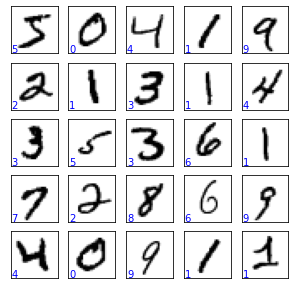

In [3]:
plot.figure(figsize = (5, 5))
for i in range(25):
    plot.subplot(5, 5, i + 1)
    plot.xticks([])
    plot.yticks([])
    plot.imshow(np.reshape(X[i, :], (28, 28)))
    plot.text(0, 27, str(y[i]), color = 'b')
    plot.set_cmap('binary') 

## Формирование обучающей и тестовой выборок

In [4]:
N_test = 10000
N_train = X.shape[0] - N_test

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = N_train, test_size = N_test, 
                                                    stratify = y, random_state = 42)

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

X_train /= 255
X_test /= 255

# y = [2, 0, 1], num_classes = 3 -> y = [[0, 0, 1], [1, 0, 0], [0, 1, 0]]
num_classes = 10
y_train = np.eye(num_classes)[y_train]
y_test = np.eye(num_classes)[y_test]

print("Размеры X_train - {}, y_train - {}".format(X_train.shape, y_train.shape))
print("Размеры X_test - {}, y_test - {}".format(X_test.shape, y_test.shape))

Размеры X_train - (60000, 784), y_train - (60000, 10)
Размеры X_test - (10000, 784), y_test - (10000, 10)


## Создание класса нейронной сети

In [5]:
class NeuralNetwork:
    def __init__(self, input_dim, hidden_dim, output_dim):
        # W0^(input_dim x hidden_dim), b0^(1 x hidden_dim)
        self.W0 = np.random.randn(input_dim, hidden_dim) * np.sqrt(2 / (input_dim + hidden_dim))
        self.b0 = np.zeros((1, hidden_dim))

        # W1^(hidden_dim x output_dim), b1^(1 x output_dim)
        self.W1 = np.random.randn(hidden_dim, output_dim) * np.sqrt(2 / (hidden_dim + output_dim))
        self.b1 = np.zeros((1, output_dim))

    def ReLU(self, x):
        return np.maximum(0, x)

    def softmax(self, x):
        exp_x = np.exp(x)
        exp_sum = np.sum(exp_x, axis = 1).reshape((len(exp_x), 1))
        return exp_x / exp_sum

    def loss(self, x, y):
        return np.mean(-np.sum(x * np.log(y), axis = 1))

    def forward(self, x):
        # x^(batch_size x input_dim), W0^(input_dim x hidden_dim), b0^(batch_size x hidden_dim)
        # v = ReLU(x * W0 + b0), v^(batch_size x hidden_dim)
        self.x1 = np.dot(x, self.W0) + self.b0
        self.v = self.ReLU(self.x1)

        # v^(batch_size x hidden_dim), W1^(hidden_dim x output_dim), b1^(batch_size x output_dim)
        # u = softmax(v * W1 + b1), u^(batch_size x output_dim)
        self.x2 = np.dot(self.v, self.W1) + self.b1
        self.u = self.softmax(self.x2)

        return self.u

    def backward(self, x, y, learning_rate):
        # u^(batch_size x output_dim), y^(batch_size x output_dim)
        # dx2 = -(1 / batch_size) * (y - u), dx2^(batch_size x output_dim)
        dx2 = -(y - self.u) / self.u.shape[0]

        # (v^T)^(hidden_dim x batch_size), dx2^(batch_size x output_dim)
        # dW1 = v^T * dx2, dW1^(hidden_dim x output_dim) -> W1^(hidden_dim x output_dim)
        dW1 = np.dot(self.v.T, dx2)

        # dx2^(batch_size x output_dim)
        # db1 = sum(dx2) from i to batch_size, db1^(1 x output_dim) -> b1^(1 x output_dim)
        db1 = np.sum(dx2, axis = 0, keepdims = True)

        # dx2^(batch_size x output_dim), (W1^T)^(output_dim x hidden_dim)
        # dx1 = ReLU_derivative(dx2 * W1^T), dx1^(batch_size x hidden_dim)
        dx1 = np.dot(dx2, self.W1.T) * np.where(self.x1 > 0, 1, 0) # ReLU_derivative

        # (x^T)^(input_dim x batch_size), dx1^(batch_size x hidden_dim)
        # dW0 = x^T * dx1, dW0^(input_dim x hidden_dim) -> W0^(input_dim x hidden_dim)
        dW0 = np.dot(x.T, dx1)

        # dx1^(batch_size x hidden_dim)
        # db0 = sum(dx1) from i to batch_size, db0^(1 x hidden_dim) -> b0^(1 x hidden_dim)
        db0 = np.sum(dx1, axis = 0, keepdims = True)

        # dW0 = x^T * ReLU_derivative(-(1 / batch_size) * (y - u) * W1^T)
        # db0 = sum(ReLU_derivative(-(1 / batch_size) * (y - u) * W1^T)) from i to batch_size
        # dW1 = -v^T * (1 / batch_size) * (y - u)
        # db1 = sum(-(1 / batch_size) * (y - u)) from i to batch_size

        self.W0 -= learning_rate * dW0
        self.b0 -= learning_rate * db0
        self.W1 -= learning_rate * dW1
        self.b1 -= learning_rate * db1

    def test(self, x, y):
        time_begin = timer()
        output = self.forward(x)
        time_end = timer()

        test_time = time_end - time_begin
        test_accuracy = np.mean(np.argmax(y, axis = 1) == np.argmax(output, axis = 1))

        print('Test accuracy = {:.5f}, test time = {:.5f} s'.
              format(test_accuracy, test_time))         

    def train(self, x, y, num_epochs, batch_size, learning_rate):
        train_time = 0
        for epoch in range(num_epochs):
            error = 0
            iter = 0

            time_begin = timer()

            while iter < len(x):
                if iter + batch_size >= len(x):
                    break

                X_batch = x[iter: iter + batch_size]
                y_batch = y[iter: iter + batch_size]

                output_batch = self.forward(X_batch)
                error += self.loss(y_batch, output_batch)

                self.backward(X_batch, y_batch, learning_rate)
                iter += batch_size

            time_end = timer()

            accuracy = np.mean(np.argmax(y, axis = 1) == np.argmax(self.forward(x), axis = 1))
            train_time += time_end - time_begin

            print('Epoch[{}]: train accuracy = {:.5f}, train error = {:.5f}, time = {:.5f} s'.
                  format(epoch + 1, accuracy, error / len(x), time_end - time_begin))
            
        print('Train time = {:.5f} s'.format(train_time))

## Обучение построенной модели

In [6]:
image_size = 28 * 28
hidden_size = 300
num_classes = 10

num_epochs = 20
batch_size = 64
learning_rate = 0.1

nn = NeuralNetwork(image_size, hidden_size, num_classes)
nn.train(X_train, y_train, num_epochs, batch_size, learning_rate)

Epoch[1]: train accuracy = 0.94098, train error = 0.00559, time = 5.06393 s
Epoch[2]: train accuracy = 0.95882, train error = 0.00292, time = 5.19115 s
Epoch[3]: train accuracy = 0.96837, train error = 0.00217, time = 5.15350 s
Epoch[4]: train accuracy = 0.97453, train error = 0.00173, time = 5.16186 s
Epoch[5]: train accuracy = 0.97882, train error = 0.00144, time = 5.34302 s
Epoch[6]: train accuracy = 0.98212, train error = 0.00123, time = 5.27221 s
Epoch[7]: train accuracy = 0.98455, train error = 0.00107, time = 5.26516 s
Epoch[8]: train accuracy = 0.98673, train error = 0.00094, time = 6.83731 s
Epoch[9]: train accuracy = 0.98835, train error = 0.00084, time = 5.23651 s
Epoch[10]: train accuracy = 0.98960, train error = 0.00075, time = 5.18371 s
Epoch[11]: train accuracy = 0.99077, train error = 0.00067, time = 5.21899 s
Epoch[12]: train accuracy = 0.99178, train error = 0.00061, time = 5.22039 s
Epoch[13]: train accuracy = 0.99245, train error = 0.00055, time = 5.16512 s
Epoch[14

## Тестирование обученной модели

In [7]:
nn.test(X_test, y_test)

Test accuracy = 0.98210, test time = 0.21653 s


# Классификация рукописных цифр из набора данных MNIST с помощью Pytorch

## Подключение библиотек

In [8]:
!pip install torchinfo

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [9]:
import torch
import torchvision
import torchvision.datasets
import torchvision.transforms
import torch.utils.data
import torch.nn
import os
from torchinfo import summary

## Загрузка набора данных MNIST

In [10]:
train_dataset = torchvision.datasets.MNIST(root = os.getcwd(), train = True,
download = True, transform = torchvision.transforms.ToTensor())

test_dataset = torchvision.datasets.MNIST(root = os.getcwd(), train = False,
download = True, transform = torchvision.transforms.ToTensor())

train_data_loader = torch.utils.data.DataLoader(train_dataset, batch_size = batch_size, shuffle = True)

test_data_loader = torch.utils.data.DataLoader(test_dataset, batch_size = batch_size, shuffle = False)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting /content/MNIST/raw/train-images-idx3-ubyte.gz to /content/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting /content/MNIST/raw/train-labels-idx1-ubyte.gz to /content/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting /content/MNIST/raw/t10k-images-idx3-ubyte.gz to /content/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting /content/MNIST/raw/t10k-labels-idx1-ubyte.gz to /content/MNIST/raw



## Создание класса нейронной сети

In [11]:
class NeuralNetworkTorch(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(NeuralNetworkTorch, self).__init__()
        self.linear_first = torch.nn.Linear(input_dim, hidden_dim)
        self.linear_second = torch.nn.Linear(hidden_dim, output_dim)
        self.ReLU = torch.nn.ReLU()

    def forward(self, x):
        self.x1 = self.linear_first(x)
        self.v = self.ReLU(self.x1)
        self.x2 = self.linear_second(self.v)
        self.u = torch.nn.functional.softmax(self.x2)
        return self.u

In [12]:
nn_torch = NeuralNetworkTorch(image_size, hidden_size, num_classes)
print(nn_torch)
summary(nn_torch)

NeuralNetworkTorch(
  (linear_first): Linear(in_features=784, out_features=300, bias=True)
  (linear_second): Linear(in_features=300, out_features=10, bias=True)
  (ReLU): ReLU()
)


Layer (type:depth-idx)                   Param #
NeuralNetworkTorch                       --
├─Linear: 1-1                            235,500
├─Linear: 1-2                            3,010
├─ReLU: 1-3                              --
Total params: 238,510
Trainable params: 238,510
Non-trainable params: 0

## Обучение построенной модели

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
nn_torch.to(device)

CrossEntropyLoss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(nn_torch.parameters(), lr = learning_rate)

In [14]:
def train_torch(x, y, num_epochs, batch_size):
    train_time = 0
    for epoch in range(num_epochs):
        error = 0
        iter = 0

        time_begin = timer()

        while iter < len(x):
            if iter + batch_size >= len(x):
                break

            X_batch = torch.autograd.Variable(torch.tensor(x[iter: iter + batch_size]))
            y_batch = torch.autograd.Variable(torch.tensor(y[iter: iter + batch_size]))

            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            
            output_batch = nn_torch(X_batch)
            loss = CrossEntropyLoss(output_batch, y_batch)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            iter += batch_size

        time_end = timer()

        accuracy = np.mean(np.argmax(y, axis = 1) == np.argmax(nn_torch(torch.tensor(X_train)).detach().numpy(), axis = 1))
        train_time += time_end - time_begin

        print('Epoch[{}]: train accuracy = {:.5f}, time = {:.5f} s'.
              format(epoch + 1, accuracy, time_end - time_begin))
        
    print('Train time = {:.5f} s'.format(train_time))

In [15]:
train_torch(X_train, y_train, num_epochs, batch_size)

Epoch[1]: train accuracy = 0.82620, time = 2.85887 s
Epoch[2]: train accuracy = 0.84125, time = 4.38371 s
Epoch[3]: train accuracy = 0.89042, time = 5.20804 s
Epoch[4]: train accuracy = 0.91772, time = 4.60766 s
Epoch[5]: train accuracy = 0.92493, time = 2.19462 s
Epoch[6]: train accuracy = 0.92958, time = 2.19374 s
Epoch[7]: train accuracy = 0.93372, time = 2.19933 s
Epoch[8]: train accuracy = 0.93740, time = 2.18244 s
Epoch[9]: train accuracy = 0.94083, time = 2.17362 s
Epoch[10]: train accuracy = 0.94355, time = 2.22030 s
Epoch[11]: train accuracy = 0.94635, time = 2.18959 s
Epoch[12]: train accuracy = 0.94888, time = 2.17726 s
Epoch[13]: train accuracy = 0.95128, time = 2.21509 s
Epoch[14]: train accuracy = 0.95318, time = 2.17687 s
Epoch[15]: train accuracy = 0.95498, time = 2.20035 s
Epoch[16]: train accuracy = 0.95682, time = 2.20447 s
Epoch[17]: train accuracy = 0.95810, time = 2.18468 s
Epoch[18]: train accuracy = 0.95932, time = 2.20237 s
Epoch[19]: train accuracy = 0.96067, 

## Тестирование обученной модели

In [16]:
def test_torch(x, y):
    time_begin = timer()
    output = nn_torch(torch.tensor(x)).detach().numpy()
    time_end = timer()

    test_time = time_end - time_begin
    test_accuracy = np.mean(np.argmax(y, axis = 1) == np.argmax(output, axis = 1))

    print('Test accuracy = {:.5f}, test time = {:.5f} s'.
          format(test_accuracy, test_time))  

In [17]:
test_torch(X_test, y_test)

Test accuracy = 0.95240, test time = 0.10754 s
